This notebook compares the output of nonpareil against sourmashconsumr accumulation curves for the built in stool microbiome metagenome data set. 

## Notebook setup

In [44]:
library(Nonpareil)
library(sourmashconsumr)
library(dplyr)
library(tibble)
library(ggplot2)

In [3]:
setwd("..")

In [51]:
# use Arcadia brand font if present
if(file.exists("inputs/SuisseIntl-Regular.otf")){
  library(showtext)
  font_add("SuisseIntl-Regular", "inputs/SuisseIntl-Regular.otf")
  showtext::showtext_auto()
  theme_arcadia <- theme_classic() +
    theme(text = element_text(family = "SuisseIntl-Regular"))
} else {
  theme_arcadia <- theme_classic()
}

Loading required package: sysfonts

Loading required package: showtextdb



## Parse nonpareil command line tool outputs

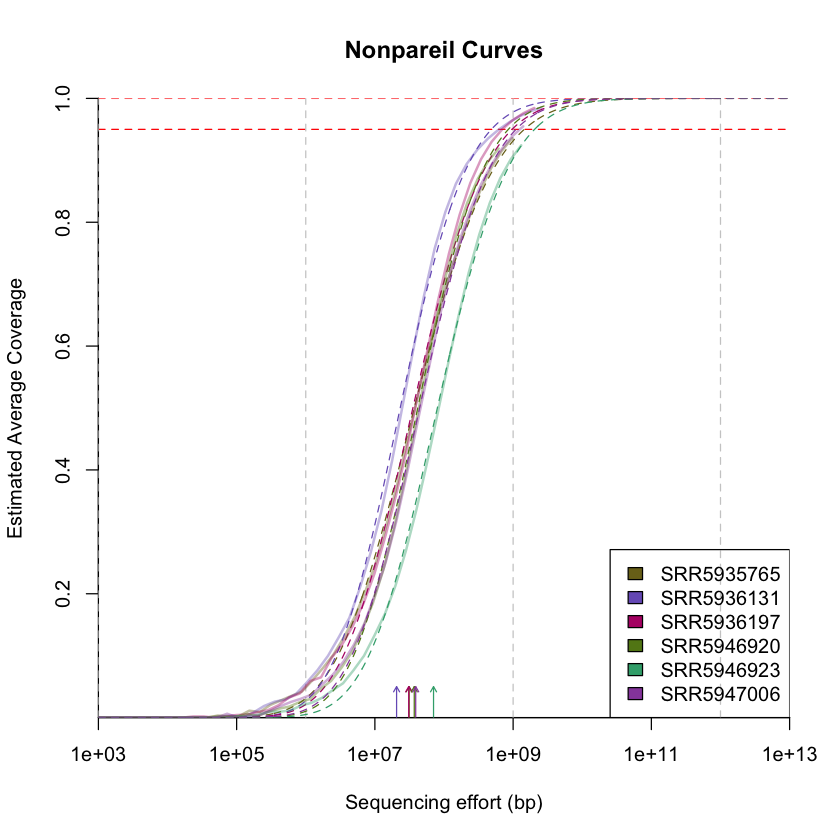

In [10]:
np <- Nonpareil.set(Sys.glob("outputs/nonpareil/SRR59*npo"))

In [12]:
summary(np)

,kappa,C,LR,modelR,LRstar,diversity
SRR5935765,0.92978,0.9356119,969705060,0.9994776,1451513094,17.26011
SRR5936131,0.98369,0.9850802,2555866453,0.9987756,485004693,16.84124
SRR5936197,0.98313,0.9845676,2022973581,0.9983349,965596468,17.24554
SRR5946920,0.91171,0.9189761,616938748,0.9994725,853078732,17.42995
SRR5946923,0.91745,0.9242636,1309556738,0.9993246,2042487188,18.07213
SRR5947006,0.95080,0.9549286,1400481354,0.9993802,1101709641,17.47794


## Sourmash accumulation curves

In [15]:
signatures_df <- #read_signature(Sys.glob("outputs/sourmash_sketch/SRR59*_fastp.sig")) %>%
  gut_signatures_df %>%
  dplyr::filter(ksize == 31)

In [16]:
rarefaction_df <- from_signatures_to_rarefaction_df(signatures_df = signatures_df)
head(rarefaction_df)

,name,num_kmers_sampled,num_kmers_observed
,<fct>,<dbl>,<dbl>
1,SRR5935765,1,1.000000
2,SRR5935765,2,1.993401
3,SRR5935765,3,2.980279
4,SRR5935765,4,3.960713
5,SRR5935765,5,4.934776
6,SRR5935765,6,5.902544


In [29]:
slope_df <- data.frame()
for(accession_i in unique(rarefaction_df$name)){
  rarefaction_accession_i <- rarefaction_df %>% 
    filter(name == accession_i)
  run_i <- diff(rarefaction_accession_i$num_kmers_sampled)
  rise_i <- diff(rarefaction_accession_i$num_kmers_observed)
  slope_i <- rise_i/run_i
  mean_slope_i <- mean(slope_i)
  min_nonzero_slope_i <- min(slope_i[slope_i != 0]) # filter out zero values and then calculate the minimum slope observed
  slope_df_i <- data.frame(accession = accession_i,
                           mean_slope = mean_slope_i,
                           min_nonzero_slope = min_nonzero_slope_i)
  slope_df <- bind_rows(slope_df, slope_df_i)
}

In [31]:
slope_df

accession,mean_slope,min_nonzero_slope
<chr>,<dbl>,<dbl>
SRR5935765,0.08393040,0.004678363
SRR5936131,0.03349255,0.003337553
SRR5936197,0.05468205,0.006737918
SRR5946920,0.10361681,0.016125092
SRR5946923,0.11628214,0.012786712
SRR5947006,0.07395317,0.008216095


## Compare nonpareil to sourmashconsumr accumulation curves

In [41]:
all <- summary(np) %>%
  as.data.frame() %>%
  rownames_to_column("accession") %>%
  left_join(slope_df, by = "accession")

In [42]:
all

accession,kappa,C,LR,modelR,LRstar,diversity,mean_slope,min_nonzero_slope
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRR5935765,0.92978,0.9356119,969705060,0.9994776,1451513094,17.26011,0.08393040,0.004678363
SRR5936131,0.98369,0.9850802,2555866453,0.9987756,485004693,16.84124,0.03349255,0.003337553
SRR5936197,0.98313,0.9845676,2022973581,0.9983349,965596468,17.24554,0.05468205,0.006737918
SRR5946920,0.91171,0.9189761,616938748,0.9994725,853078732,17.42995,0.10361681,0.016125092
SRR5946923,0.91745,0.9242636,1309556738,0.9993246,2042487188,18.07213,0.11628214,0.012786712
SRR5947006,0.95080,0.9549286,1400481354,0.9993802,1101709641,17.47794,0.07395317,0.008216095


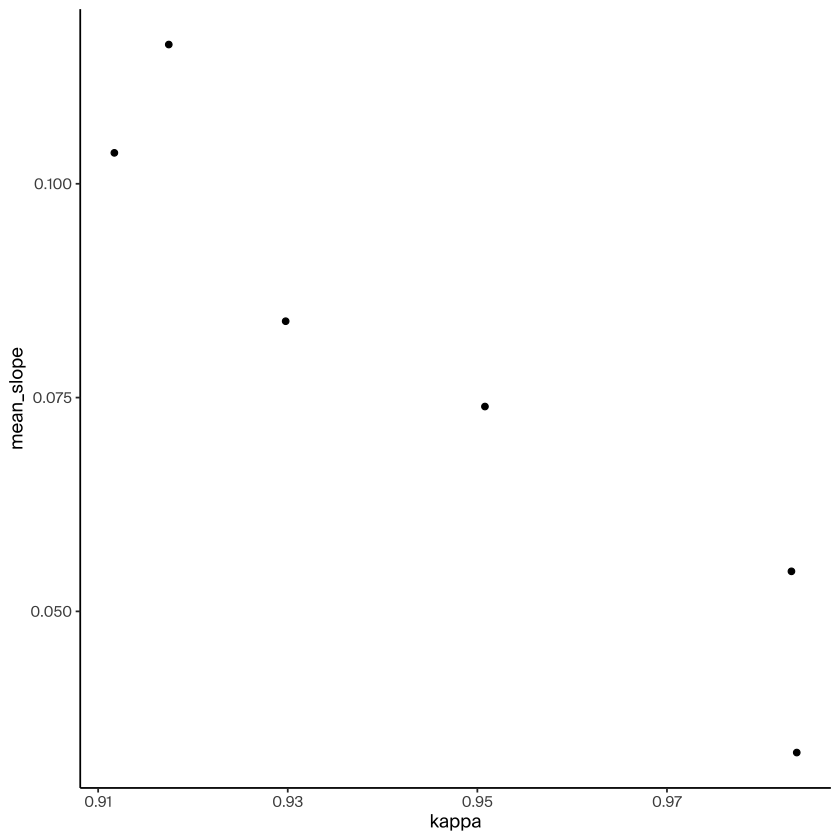

In [52]:
ggplot(all, aes(x = kappa, y = mean_slope)) +
  geom_point() +
  theme_arcadia

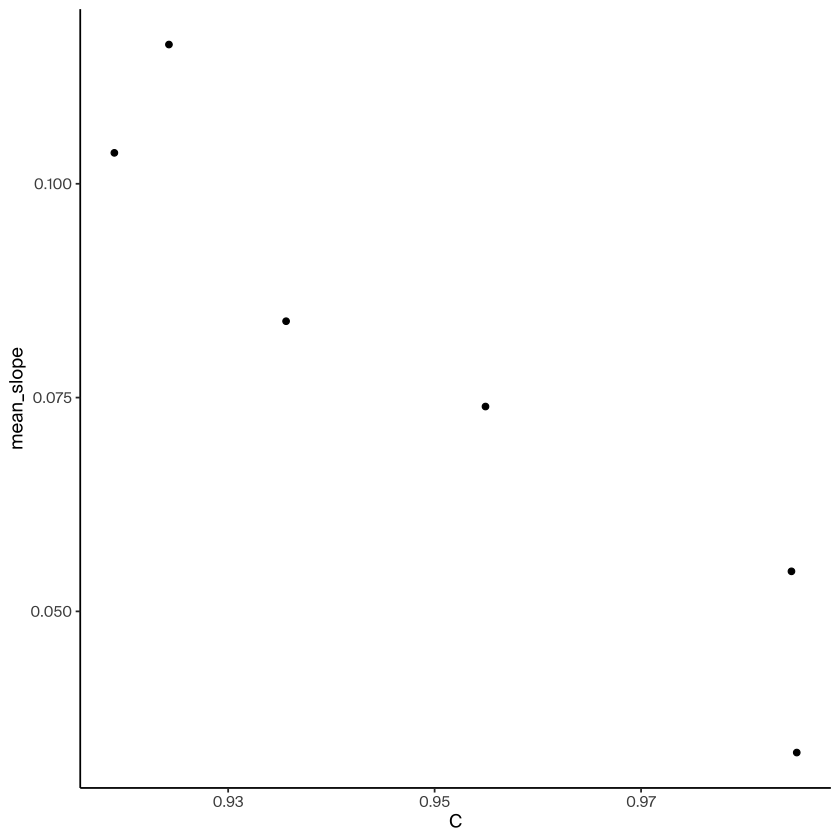

In [53]:
ggplot(all, aes(x = C, y = mean_slope)) +
  geom_point() + 
  theme_arcadia

In [48]:
cor(all[ , -1])

,kappa,C,LR,modelR,LRstar,diversity,mean_slope,min_nonzero_slope
kappa,1.0000000,0.9999997,0.9162031,-0.8661357,-0.6091063,-0.6903355,-0.9481963,-0.7448054
C,0.9999997,1.0000000,0.9161027,-0.8658535,-0.6089115,-0.6902806,-0.9482188,-0.7451045
LR,0.9162031,0.9161027,1.0000000,-0.8099399,-0.4524461,-0.5338875,-0.8491136,-0.6827142
modelR,-0.8661357,-0.8658535,-0.8099399,1.0000000,0.4332228,0.4580770,0.7187662,0.4586599
LRstar,-0.6091063,-0.6089115,-0.4524461,0.4332228,1.0000000,0.8689395,0.7555092,0.3154371
diversity,-0.6903355,-0.6902806,-0.5338875,0.4580770,0.8689395,1.0000000,0.8703127,0.6848247
mean_slope,-0.9481963,-0.9482188,-0.8491136,0.7187662,0.7555092,0.8703127,1.0000000,0.8084693
min_nonzero_slope,-0.7448054,-0.7451045,-0.6827142,0.4586599,0.3154371,0.6848247,0.8084693,1.0000000
